In [1]:
import cooler
import cooltools
import bioframe

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe

from cooltools.lib.numutils import fill_diag
from cooltools.lib import make_cooler_view

from matplotlib.ticker import EngFormatter
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x')
        
def rectangles_around_dots(dots_df, region, loc="upper", lw=1, ec="cyan", fc="none"):
    """
    yield a series of rectangles around called dots in a given region
    """
    # select dots from the region:
    df_reg = bioframe.select(
        bioframe.select(dots_df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2"),
    )
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1, s2, e1, e2 in df_reg[["start1", "start2", "end1", "end2"]].itertuples(index=False):
        width1 = e1 - s1
        width2 = e2 - s2
        if loc == "upper":
            yield patches.Rectangle((s2, s1), width2, width1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((s1, s2), width1, width2, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")
        
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

#### Data source: https://cotneylab.cam.uchc.edu/~jcotney/CRANIOFACIAL_HUB/hg38/Combined_CRANIOFACIAL_HiC.allValidPairs.hic

In [2]:
data_dir = '/data/nikita_data/hic_alek/'
mcool_file = 'Combined_CRANIOFACIAL_HiC.allValidPairs_balanced.mcool' 
mcool_path = os.path.join(data_dir, mcool_file)
clr = cooler.Cooler(f'{mcool_path}::resolutions/10000')
cooler.rename_chroms(clr, {chrom: 'chr' + chrom if not chrom.startswith('chr') else chrom for chrom in clr.chromnames })
resolution = clr.binsize

In [3]:
cooler.fileops.list_coolers(mcool_path)

['/resolutions/5000',
 '/resolutions/10000',
 '/resolutions/50000',
 '/resolutions/100000']

In [4]:
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)

hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)

In [5]:
cvd = cooltools.expected_cis(
    clr=clr,
    view_df=hg38_arms,
    smooth=False,
    aggregate_smoothed=False,
    nproc=10
)

INFO:root:creating a Pool of 10 workers


In [6]:
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
insulation_table = cooltools.insulation(clr, windows, verbose=True)

INFO:root:fallback to serial implementation.
INFO:root:Processing region chr1
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr4
INFO:root:Processing region chr5
INFO:root:Processing region chr6
INFO:root:Processing region chr7
INFO:root:Processing region chrX
INFO:root:Processing region chr8
INFO:root:Processing region chr9
INFO:root:Processing region chr11
INFO:root:Processing region chr10
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr20
INFO:root:Processing region chr19
INFO:root:Processing region chrY
INFO:root:Processing region chr22
INFO:root:Processing region chr21


(10500000.0, 13200000.0)

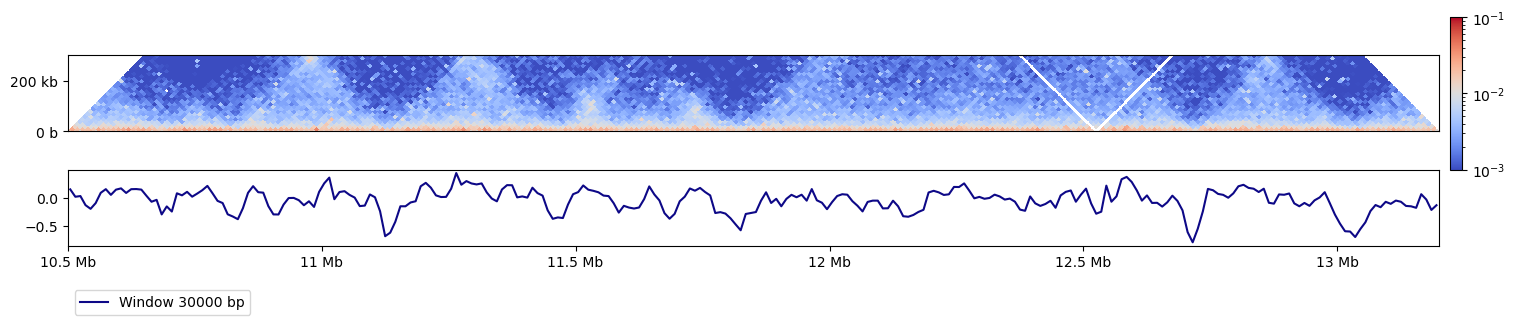

In [7]:
start = 10_500_000
end = start+ 90*windows[0]
region = ('chr2', start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)
f, ax = plt.subplots(figsize=(18, 6))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='coolwarm')
ax.set_aspect(0.5)
ax.set_ylim(0, 10*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region['log2_insulation_score_'+str(windows[0])],
            label=f'Window {windows[0]} bp')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

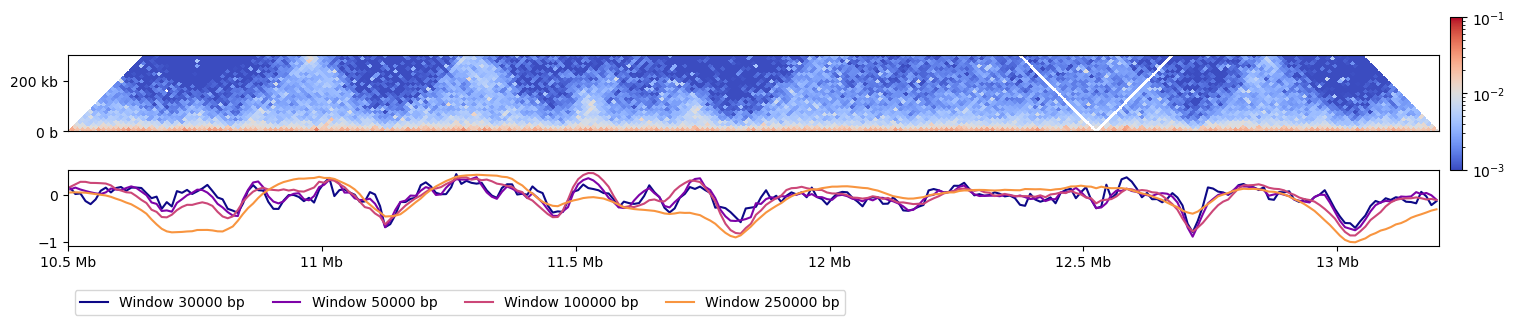

In [8]:
for res in windows[1:]:
    ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region[f'log2_insulation_score_{res}'], label=f'Window {res} bp')
ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);
f

(10500000.0, 13200000.0)

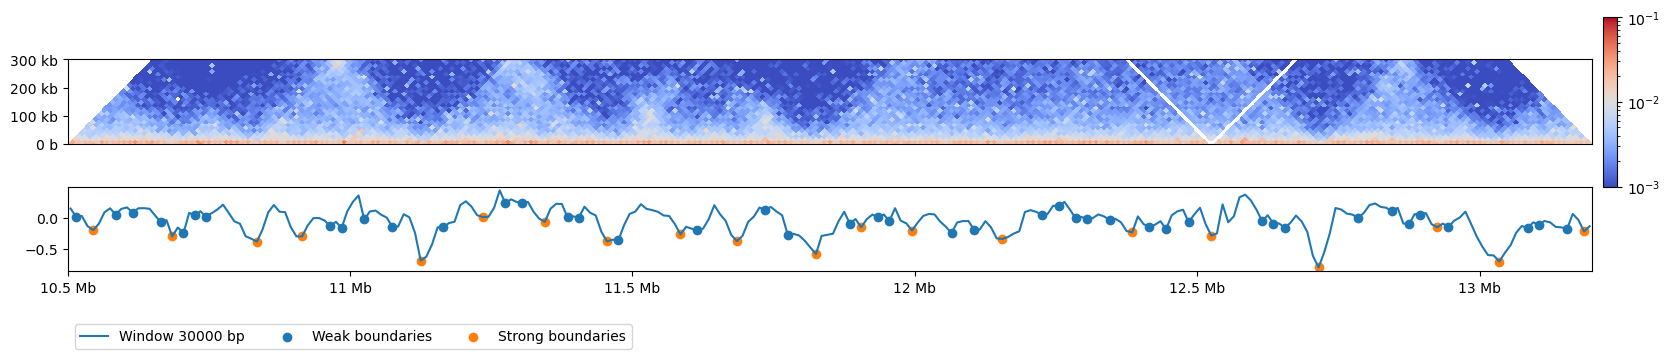

In [9]:
f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='coolwarm')
ax.set_aspect(0.5)
ax.set_ylim(0, 10*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

window = windows[0]

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{window}'], label=f'Window {window} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{window}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{window}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{window}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{window}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{window}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

(10500000.0, 13200000.0)

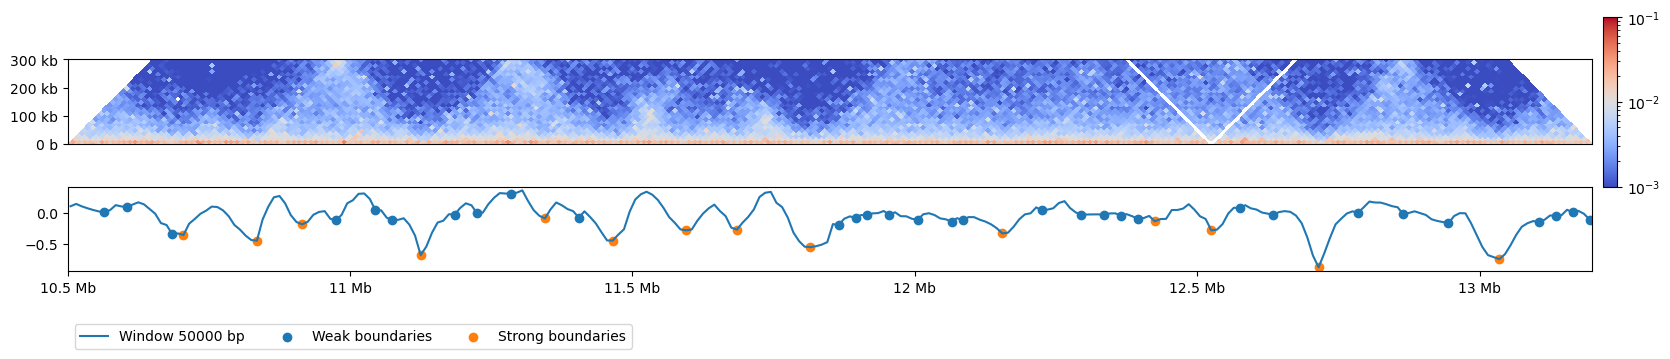

In [10]:
f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='coolwarm')
ax.set_aspect(0.5)
ax.set_ylim(0, 10*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

window = windows[1]

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{window}'], label=f'Window {window} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{window}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{window}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{window}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{window}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{window}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

(10500000.0, 13200000.0)

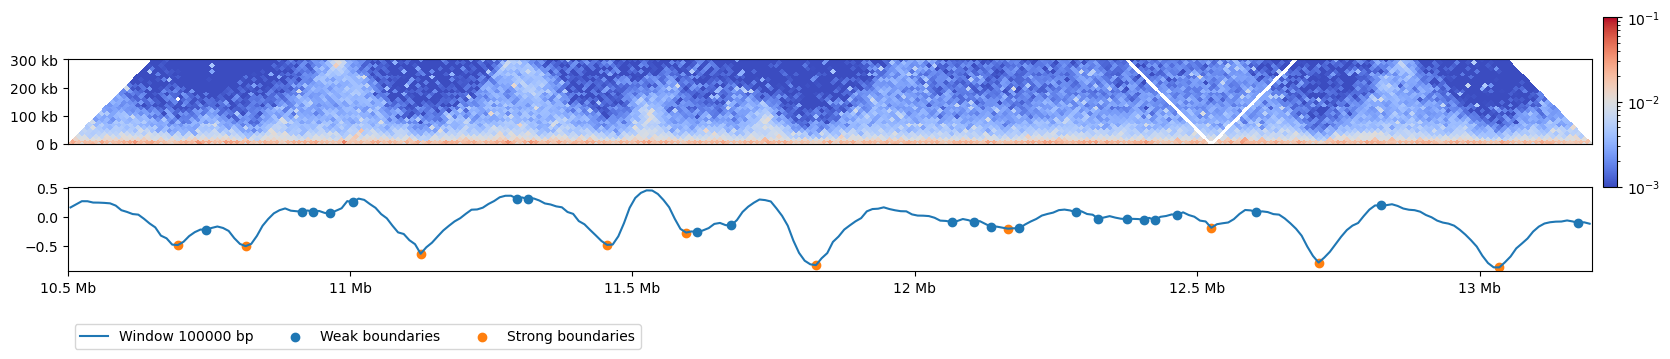

In [11]:
f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='coolwarm')
ax.set_aspect(0.5)
ax.set_ylim(0, 10*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

window = windows[2]

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{window}'], label=f'Window {window} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{window}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{window}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{window}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{window}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{window}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

(10500000.0, 13200000.0)

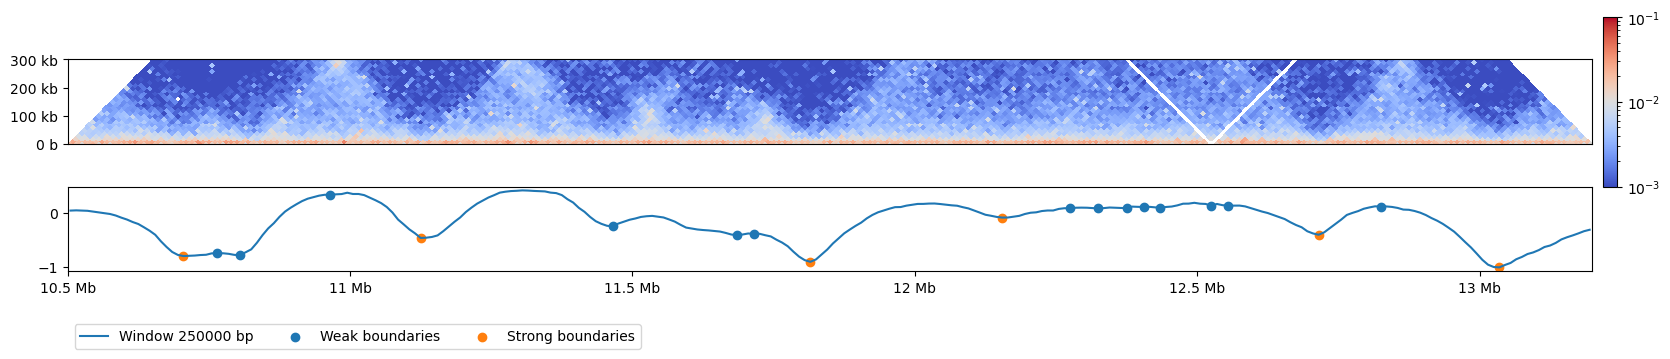

In [12]:
f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='coolwarm')
ax.set_aspect(0.5)
ax.set_ylim(0, 10*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

window = windows[3]

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{window}'], label=f'Window {window} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{window}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{window}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{window}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{window}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{window}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

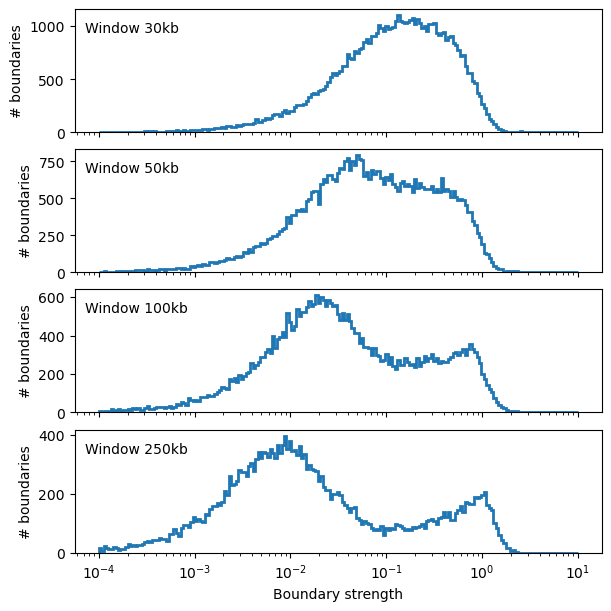

In [13]:
histkwargs = dict(
    bins=10**np.linspace(-4,1,200),
    histtype='step',
    lw=2,
)

f, axs = plt.subplots(len(windows),1, sharex=True, figsize=(6,6), constrained_layout=True)
for i, (w, ax) in enumerate(zip(windows, axs)):
    ax.hist(
        insulation_table[f'boundary_strength_{w}'],
        **histkwargs
    )
    ax.text(0.02, 0.9,
             f'Window {w//1000}kb',
             ha='left',
             va='top',
             transform=ax.transAxes)

    ax.set(
        xscale='log',
        ylabel='# boundaries'
    )

axs[-1].set(xlabel='Boundary strength');

[Text(0.5, 0, 'Boundary strength')]

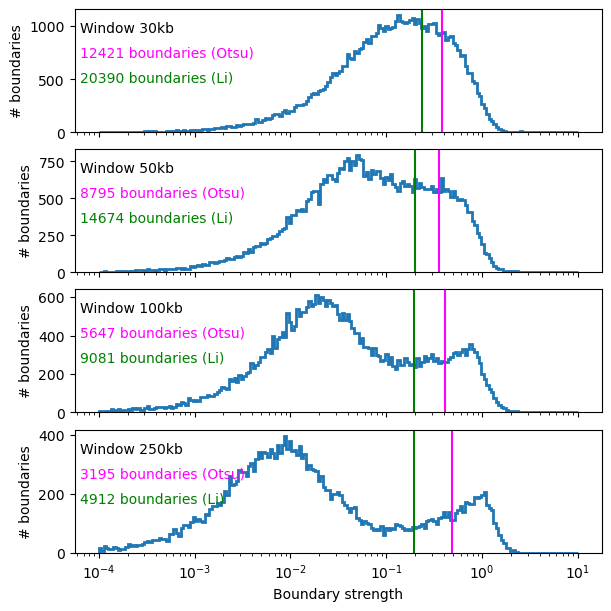

In [14]:
from skimage.filters import threshold_li, threshold_otsu

f, axs = plt.subplots(len(windows), 1, sharex=True, figsize=(6,6), constrained_layout=True)
thresholds_li = {}
thresholds_otsu = {}
for i, (w, ax) in enumerate(zip(windows, axs)):
    ax.hist(
        insulation_table[f'boundary_strength_{w}'],
        **histkwargs
    )
    thresholds_li[w] = threshold_li(insulation_table[f'boundary_strength_{w}'].dropna().values)
    thresholds_otsu[w] = threshold_otsu(insulation_table[f'boundary_strength_{w}'].dropna().values)
    n_boundaries_li = (insulation_table[f'boundary_strength_{w}'].dropna()>=thresholds_li[w]).sum()
    n_boundaries_otsu = (insulation_table[f'boundary_strength_{w}'].dropna()>=thresholds_otsu[w]).sum()
    ax.axvline(thresholds_li[w], c='green')
    ax.axvline(thresholds_otsu[w], c='magenta')
    ax.text(0.01, 0.9,
             f'Window {w//1000}kb',
             ha='left',
             va='top',
             transform=ax.transAxes)
    ax.text(0.01, 0.7,
            f'{n_boundaries_otsu} boundaries (Otsu)',
            c='magenta',
            ha='left',
            va='top',
            transform=ax.transAxes)
    ax.text(0.01, 0.5,
            f'{n_boundaries_li} boundaries (Li)',
            c='green',
            ha='left',
            va='top',
            transform=ax.transAxes)

    ax.set(
        xscale='log',
        ylabel='# boundaries'
    )

axs[-1].set(xlabel='Boundary strength')

### So 100kb is the best

In [15]:
boundaries = insulation_table.query('is_boundary_100000')
boundaries['pos'] = boundaries[['start', 'end']].mean(axis=1).astype(int)

boundaries = boundaries[['chrom', 'start', 'end', 'pos', 'boundary_strength_100000']]
boundaries.to_csv('Domain_boundaries_100kb.csv')

/tmp/ipykernel_1790743/3098439160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boundaries['pos'] = boundaries[['start', 'end']].mean(axis=1).astype(int)
